# Mini-Lab Logistic Regression and SVMs 

### Peter Kouvaris, Ireti Fasere, Dan Freeman, Tim McWilliams

Our team reviewed the accuracy that is achievable when using support vector machines and logistic regression. Our data set includes a variable, *income_binary*, with two outcomes that we attempt to predict. Data was split into an 80% training set and 20% testing set using a few different versions of SciKit's sampling tools. 

In the following code, we review how different model outcomes change. We review what happens when all variables are included, a reduced number of variables are included, varying kernel types are used, varying parameters are fed to functions, variables are transformed, and the effects of robust methods like feature selection.

Our conclusions: 

* Both models provide a substantial level of classifcation accuracy compared to methods previously studied. 


* Our most accurate logistic regression model scored 84.47% accuracy while our most accurate support vector machine scored 86.6%.


* Both required substantial training time compared to the near instantaneous calculation time of linear regression models we had used in the past. Logistic regression models have a tendency to provide slightly lower accuracy but faster calculation time. Support vector machines act in the reverse, in that they train slower, but provide higher accuracy. For tasks that require constant re-training, logistic regression would be beneficial. For tasks that did not require as frequent training and demanded every bit of accuracy one could get, support vector machines would be the best choice.


* Certain parameters greatly increase the calculation time of each algorithm. The specifics of these are discussed below in each algorithm's respective sections.

In [245]:
# Imports for data-preprocessing
import pandas as pd
import numpy as np
from __future__ import print_function

# Import feature selection/LogR libraries
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# SVM using SVC
from sklearn.svm import SVC

# Viz libraries
import matplotlib.pyplot as plt
from string import ascii_letters
import seaborn as sns
%matplotlib inline

In [265]:
# Import data 
df = pd.read_csv('../data/master.csv')

In [266]:
# Delete unwanted variables
del df['workclass']
del df['education']
del df['education_num']
del df['marital_status']
del df['occupation']
del df['native_country'] 
del df['Unnamed: 0']

In [267]:
# Check df again
df.head()

,age,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income_binary,condensed_education,continent,condensed_marital,condensed_workclass
0,39,Not-in-family,White,Male,2174,0,40,<=50K,Bachelors,United States,Never,Government
1,50,Husband,White,Male,0,0,13,<=50K,Bachelors,United States,Married,Self-Employed
2,38,Not-in-family,White,Male,0,0,40,<=50K,High School Graduate,United States,Divorced/Separated,Private
3,53,Husband,Black,Male,0,0,40,<=50K,No High School Diploma,United States,Married,Private
4,28,Wife,Black,Female,0,0,40,<=50K,Bachelors,Caribbean,Married,Private


### Training and Testing Split

The data set was split into two separte sets.

In [268]:
from sklearn.model_selection import StratifiedShuffleSplit

if 'income_binary' in df:
    y = df['income_binary'].values #get values we need 
    del df['income_binary']        #get rid of the class label
    X = df.values            #use everything else to predict 
    
X = pd.get_dummies(df).values

# Split the data into 20% Test and 80% Train
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)
sss.get_n_splits(X, y) #retreving the splits 

10

In [235]:
print(sss)

StratifiedShuffleSplit(n_splits=10, random_state=111, test_size=0.2,
            train_size=None)


In [269]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [15163 16279 29246 ..., 21159 41049 17832] TEST: [43578  1917 17027 ..., 22163 39121  5217]
TRAIN: [12894 40784 33210 ..., 40386 25846 36294] TEST: [22078 13800    49 ..., 31283 31586  5940]
TRAIN: [16738 39693 30388 ...,   328 33912 39362] TEST: [24310 48705 25069 ..., 47258 14625 39292]
TRAIN: [ 7391 39777 43398 ...,  8978 24399 34458] TEST: [ 8836  1328 27156 ..., 47164 10476 15648]
TRAIN: [16863 33361 41054 ..., 26744 47828 11941] TEST: [18495 35842 20752 ..., 46535  4696 46808]
TRAIN: [ 5743 21257 30549 ...,  5927  7506 19162] TEST: [21737 30911  7484 ..., 19717 27662 19780]
TRAIN: [18797 40559 21393 ..., 47376 19268 42562] TEST: [13861 34766  4320 ..., 42723 30153 11994]
TRAIN: [36977 11147 24500 ..., 40130 15262 22626] TEST: [13974 35810 43678 ...,  7735 14376 40480]
TRAIN: [32752 37107 19197 ..., 26015 32870  7076] TEST: [36370 13966 29812 ..., 20543 23045 34324]
TRAIN: [22441 41471 48039 ..., 32784  4446 45905] TEST: [  934  1627 37667 ...,  4950 44845 21169]


In [202]:
correlation_matrix = np.corrcoef(X.T)
print(correlation_matrix)

[[ 1.          0.07722902  0.05694383 ..., -0.19126318  0.17852802
   0.02675379]
 [ 0.07722902  1.         -0.03144077 ..., -0.03698639  0.08293252
  -0.01927657]
 [ 0.05694383 -0.03144077  1.         ..., -0.0251755   0.03484551
  -0.01227187]
 ..., 
 [-0.19126318 -0.03698639 -0.0251755  ...,  1.         -0.53984939
  -0.37366187]
 [ 0.17852802  0.08293252  0.03484551 ..., -0.53984939  1.         -0.08886058]
 [ 0.02675379 -0.01927657 -0.01227187 ..., -0.37366187 -0.08886058  1.        ]]


In [203]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Abalone Feature Correlation')
    labels=['age','race', 'sex', 
            'condensed_education', 'continent', 'condensed_marital', 'condensed_workclass']
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, .75,.8,.85,.90,.95,1])
    plt.show()

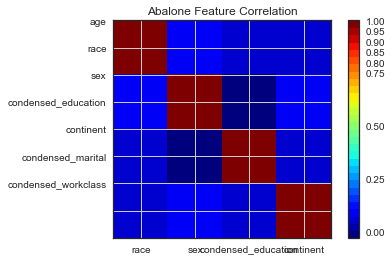

In [204]:
correlation_matrix(df)

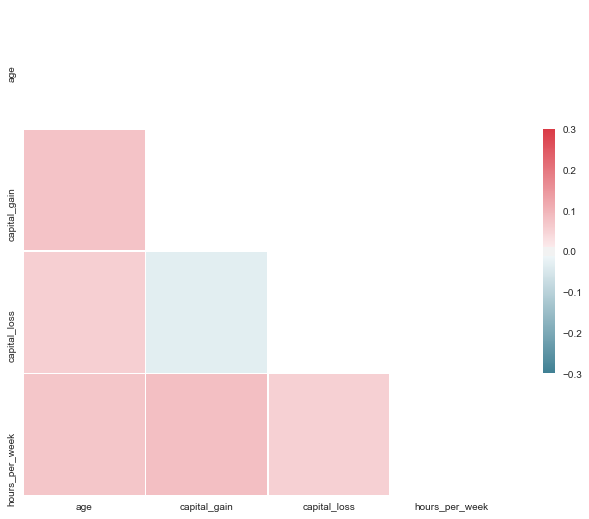

In [171]:
# Correlation between continuous variables 

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Feature Selection

The goal here is to figure out how incorporating a certain feature selection method, recursive feature elimination (RFE), into our logistic regression models changes the prediction accuracy. The RFE selects features by recursively choosing smaller and smaller groups of features. The selection starts off with all of the features in the data set. Then the least important features are pruned off of the current feature set. This is recursively repeated on the pruned set until it stops on the number that is chosen. Once the feature selection is complete, those chosen features will be used in the model.

From the below feature selection models, we can gain further insight into which variables provide the most weight.

In [262]:
# Feature extraction #1
# Set number of features to 3
model = LogisticRegression(penalty='l2', C=1.0)
rfe = RFE(model, 10)
fit = rfe.fit(X, y)
print("Num Features:", fit.n_features_)
features = pd.Series(fit.support_, index = X.columns)
print("Selected Features: \n", features[features==True])
print("Feature Ranking:", fit.ranking_)



Num Features: 10
Selected Features: 
 relationship_ Husband                         True
relationship_ Own-child                       True
relationship_ Wife                            True
condensed_education_Associates                True
condensed_education_Doctorate                 True
condensed_education_High School Graduate      True
condensed_education_No High School Diploma    True
condensed_education_Some College              True
continent_Latin America                       True
continent_Mexico                              True
dtype: bool
Feature Ranking: [30 32 31 28  1 17  6  1 13  1  8 29 16 18 20  4 21  1 12  1  1  5  1  1 19
  9 23 10  1  1 15 11 26 14  7  3 22 27 24 25  2]


In [263]:
# Feature extraction #2
# Set number of features to 5
model2 = LogisticRegression(penalty='l2', C=1.0)
rfe2 = RFE(model2, 20)
fit2 = rfe2.fit(X, y)
print("Num Features:", fit2.n_features_)
features2 = pd.Series(fit2.support_, index = X.columns)
print("Selected Features: \n", features2[features2==True])
print("Selected Features:", fit2.support_)
print("Feature Ranking:", fit2.ranking_)

Num Features: 20
Selected Features: 
 relationship_ Husband                              True
relationship_ Other-relative                       True
relationship_ Own-child                            True
relationship_ Wife                                 True
race_ Amer-Indian-Eskimo                           True
sex_ Female                                        True
condensed_education_Associates                     True
condensed_education_Doctorate                      True
condensed_education_High School Graduate           True
condensed_education_Masters/Professional School    True
condensed_education_No High School Diploma         True
condensed_education_Some College                   True
continent_Canada                                   True
continent_Europe                                   True
continent_Latin America                            True
continent_Mexico                                   True
continent_United States                            True
condensed_

In [250]:
# Feature extraction #3
# Set number of features to 10
model3 = LogisticRegression(penalty='l2', C=1.0)
rfe3 = RFE(model3, 50)
fit3 = rfe3.fit(X, y)
print("Num Features:", fit3.n_features_)
features3 = pd.Series(fit3.support_, index = X.columns)
print("Selected Features: \n", features3[features3==True])
print("Selected Features:", fit3.support_)
print("Feature Ranking:", fit3.ranking_)

Num Features: 41
Selected Features: 
 age                                                True
capital_gain                                       True
capital_loss                                       True
hours_per_week                                     True
relationship_ Husband                              True
relationship_ Not-in-family                        True
relationship_ Other-relative                       True
relationship_ Own-child                            True
relationship_ Unmarried                            True
relationship_ Wife                                 True
race_ Amer-Indian-Eskimo                           True
race_ Asian-Pac-Islander                           True
race_ Black                                        True
race_ Other                                        True
race_ White                                        True
sex_ Female                                        True
sex_ Male                                          True
condensed_

### Logistic Regression

We begin with a simple logistic regression model

In [270]:
# RFE model #1

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe.fit(X_train,y_train)  # train object
    y_hat_rfe = rfe.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe1 = mt.accuracy_score(y_test,y_hat_rfe)
    conf_rfe1 = mt.confusion_matrix(y_test,y_hat_rfe)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe1 )
    print("confusion matrix\n",conf_rfe1)
    iter_num+=1


====Iteration 0  ====
accuracy 0.81963353465
confusion matrix
 [[7077  354]
 [1408  930]]
====Iteration 1  ====
accuracy 0.820042993142
confusion matrix
 [[7062  369]
 [1389  949]]
====Iteration 2  ====
accuracy 0.822090285597
confusion matrix
 [[7062  369]
 [1369  969]]
====Iteration 3  ====
accuracy 0.815027126625
confusion matrix
 [[7033  398]
 [1409  929]]
====Iteration 4  ====
accuracy 0.823625754939
confusion matrix
 [[7075  356]
 [1367  971]]
====Iteration 5  ====
accuracy 0.82290920258
confusion matrix
 [[7074  357]
 [1373  965]]
====Iteration 6  ====
accuracy 0.823318661071
confusion matrix
 [[7039  392]
 [1334 1004]]
====Iteration 7  ====
accuracy 0.817586242195
confusion matrix
 [[7050  381]
 [1401  937]]
====Iteration 8  ====
accuracy 0.821680827106
confusion matrix
 [[7056  375]
 [1367  971]]
====Iteration 9  ====
accuracy 0.823318661071
confusion matrix
 [[7084  347]
 [1379  959]]


In [271]:
# Get the mean accuracy

# Load the accuracies
accuracies_rfe = cross_val_score(rfe, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_rfe = np.mean(accuracies_rfe)
print("The mean accuracy for this model is ", mean_rfe)

The mean accuracy for this model is  0.820923328898


In [272]:
# RFE model #2

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe2.fit(X_train,y_train)  # train object
    y_hat_rfe2 = rfe2.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe2 = mt.accuracy_score(y_test,y_hat_rfe2)
    conf_rfe2 = mt.confusion_matrix(y_test,y_hat_rfe2)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe2 )
    print("confusion matrix\n",conf_rfe2)
    iter_num+=1


====Iteration 0  ====
accuracy 0.820554816256
confusion matrix
 [[7082  349]
 [1404  934]]
====Iteration 1  ====
accuracy 0.821271368615
confusion matrix
 [[7053  378]
 [1368  970]]
====Iteration 2  ====
accuracy 0.822499744088
confusion matrix
 [[7047  384]
 [1350  988]]
====Iteration 3  ====
accuracy 0.816460231344
confusion matrix
 [[7010  421]
 [1372  966]]
====Iteration 4  ====
accuracy 0.826184870509
confusion matrix
 [[7064  367]
 [1331 1007]]
====Iteration 5  ====
accuracy 0.824342307299
confusion matrix
 [[7060  371]
 [1345  993]]
====Iteration 6  ====
accuracy 0.823932848807
confusion matrix
 [[7042  389]
 [1331 1007]]
====Iteration 7  ====
accuracy 0.818098065309
confusion matrix
 [[7029  402]
 [1375  963]]
====Iteration 8  ====
accuracy 0.823932848807
confusion matrix
 [[7047  384]
 [1336 1002]]
====Iteration 9  ====
accuracy 0.82475176579
confusion matrix
 [[7068  363]
 [1349  989]]


In [273]:
# Get the mean accuarcy 

# Load the accuracies
accuracies_rfe2 = cross_val_score(rfe2, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_rfe2 = np.mean(accuracies_rfe2)
print("The mean accuracy for this model is ", mean_rfe2)

The mean accuracy for this model is  0.822202886682


In [255]:
# RFE model #3

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    rfe3.fit(X_train,y_train)  # train object
    y_hat_rfe3 = rfe3.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc_rfe3 = mt.accuracy_score(y_test,y_hat_rfe3)
    conf_rfe3 = mt.confusion_matrix(y_test,y_hat_rfe3)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc_rfe3 )
    print("confusion matrix\n",conf_rfe3)
    iter_num+=1


====Iteration 0  ====
accuracy 0.843382127137
confusion matrix
 [[6958  473]
 [1057 1281]]
====Iteration 1  ====
accuracy 0.848705087522
confusion matrix
 [[6941  490]
 [ 988 1350]]
====Iteration 2  ====
accuracy 0.842972668646
confusion matrix
 [[6901  530]
 [1004 1334]]
====Iteration 3  ====
accuracy 0.839901729962
confusion matrix
 [[6911  520]
 [1044 1294]]
====Iteration 4  ====
accuracy 0.845634148838
confusion matrix
 [[6928  503]
 [1005 1333]]
====Iteration 5  ====
accuracy 0.848193264408
confusion matrix
 [[6982  449]
 [1034 1304]]
====Iteration 6  ====
accuracy 0.844405773365
confusion matrix
 [[6892  539]
 [ 981 1357]]
====Iteration 7  ====
accuracy 0.839697000717
confusion matrix
 [[6897  534]
 [1032 1306]]
====Iteration 8  ====
accuracy 0.846248336575
confusion matrix
 [[6947  484]
 [1018 1320]]
====Iteration 9  ====
accuracy 0.84901218139
confusion matrix
 [[6973  458]
 [1017 1321]]


In [256]:
# Get the mean accuarcy 
from sklearn.model_selection import cross_val_score

# Load the accuracies
accuracies_rfe3 = cross_val_score(rfe3, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_rfe3 = np.mean(accuracies_rfe3)
print("The mean accuracy for this model is ", mean_rfe3)

The mean accuracy for this model is  0.844815231856


In [212]:
# LR model #1
lr_clf = LogisticRegression(penalty='l2', C=1.0) # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1


====Iteration 0  ====
accuracy 0.843382127137
confusion matrix
 [[6958  473]
 [1057 1281]]
====Iteration 1  ====
accuracy 0.848705087522
confusion matrix
 [[6941  490]
 [ 988 1350]]
====Iteration 2  ====
accuracy 0.842972668646
confusion matrix
 [[6901  530]
 [1004 1334]]
====Iteration 3  ====
accuracy 0.839901729962
confusion matrix
 [[6911  520]
 [1044 1294]]
====Iteration 4  ====
accuracy 0.845634148838
confusion matrix
 [[6928  503]
 [1005 1333]]
====Iteration 5  ====
accuracy 0.848193264408
confusion matrix
 [[6982  449]
 [1034 1304]]
====Iteration 6  ====
accuracy 0.844405773365
confusion matrix
 [[6892  539]
 [ 981 1357]]
====Iteration 7  ====
accuracy 0.839697000717
confusion matrix
 [[6897  534]
 [1032 1306]]
====Iteration 8  ====
accuracy 0.846248336575
confusion matrix
 [[6947  484]
 [1018 1320]]
====Iteration 9  ====
accuracy 0.84901218139
confusion matrix
 [[6973  458]
 [1017 1321]]


In [213]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf = cross_val_score(lr_clf, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf = np.mean(accuracies_lr_clf)
print("The mean accuracy for this model is ", mean_lr_clf)

The mean accuracy for this model is  0.844815231856


In [214]:
# LR model #2
lr_clf2 = LogisticRegression(penalty='l1', C=1.0) # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices2, test_indices2 in sss.split(X,y): 
    X_train2 = X[train_indices2]  # train indices for X
    y_train2 = y[train_indices2]  # train indices for y
    
    X_test2 = X[test_indices2]    # test indices for X
    y_test2 = y[test_indices2]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf2.fit(X_train2,y_train2)  # train object
    y_hat2 = lr_clf2.predict(X_test2) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc2 = mt.accuracy_score(y_test2,y_hat2)
    conf2 = mt.confusion_matrix(y_test2,y_hat2)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc2 )
    print("confusion matrix\n",conf2)
    iter_num+=1


====Iteration 0  ====
accuracy 0.844815231856
confusion matrix
 [[6948  483]
 [1033 1305]]
====Iteration 1  ====
accuracy 0.848705087522
confusion matrix
 [[6935  496]
 [ 982 1356]]
====Iteration 2  ====
accuracy 0.843075033269
confusion matrix
 [[6897  534]
 [ 999 1339]]
====Iteration 3  ====
accuracy 0.839799365339
confusion matrix
 [[6884  547]
 [1018 1320]]
====Iteration 4  ====
accuracy 0.846350701198
confusion matrix
 [[6929  502]
 [ 999 1339]]
====Iteration 5  ====
accuracy 0.848602722899
confusion matrix
 [[6961  470]
 [1009 1329]]
====Iteration 6  ====
accuracy 0.845122325724
confusion matrix
 [[6900  531]
 [ 982 1356]]
====Iteration 7  ====
accuracy 0.840004094585
confusion matrix
 [[6885  546]
 [1017 1321]]
====Iteration 8  ====
accuracy 0.846555430443
confusion matrix
 [[6925  506]
 [ 993 1345]]
====Iteration 9  ====
accuracy 0.848807452145
confusion matrix
 [[6965  466]
 [1011 1327]]


In [215]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf2 = cross_val_score(lr_clf2, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf2 = np.mean(accuracies_lr_clf2)
print("The mean accuracy for this model is ", mean_lr_clf2)

The mean accuracy for this model is  0.845163271573


In [216]:
# LR model #3
lr_clf3 = LogisticRegression(penalty='l1', C=1.0, class_weight='balanced') # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices3, test_indices3 in sss.split(X,y): 
    X_train3 = X[train_indices3]  # train indices for X
    y_train3 = y[train_indices3]  # train indices for y
    
    X_test3 = X[test_indices3]    # test indices for X
    y_test3 = y[test_indices3]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf3.fit(X_train3,y_train3)  # train object
    y_hat3 = lr_clf3.predict(X_test3) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc3 = mt.accuracy_score(y_test3,y_hat3)
    conf3 = mt.confusion_matrix(y_test3,y_hat3)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc3 )
    print("confusion matrix\n",conf3)
    iter_num+=1


====Iteration 0  ====
accuracy 0.79977479783
confusion matrix
 [[5824 1607]
 [ 349 1989]]
====Iteration 1  ====
accuracy 0.799467703962
confusion matrix
 [[5809 1622]
 [ 337 2001]]
====Iteration 2  ====
accuracy 0.792711638858
confusion matrix
 [[5777 1654]
 [ 371 1967]]
====Iteration 3  ====
accuracy 0.797010953015
confusion matrix
 [[5782 1649]
 [ 334 2004]]
====Iteration 4  ====
accuracy 0.800184256321
confusion matrix
 [[5836 1595]
 [ 357 1981]]
====Iteration 5  ====
accuracy 0.806326133688
confusion matrix
 [[5852 1579]
 [ 313 2025]]
====Iteration 6  ====
accuracy 0.795884942164
confusion matrix
 [[5781 1650]
 [ 344 1994]]
====Iteration 7  ====
accuracy 0.796396765278
confusion matrix
 [[5793 1638]
 [ 351 1987]]
====Iteration 8  ====
accuracy 0.794861295936
confusion matrix
 [[5766 1665]
 [ 339 1999]]
====Iteration 9  ====
accuracy 0.800593714812
confusion matrix
 [[5824 1607]
 [ 341 1997]]


In [217]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf3 = cross_val_score(lr_clf3, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf3 = np.mean(accuracies_lr_clf3)
print("The mean accuracy for this model is ", mean_lr_clf3)

The mean accuracy for this model is  0.798454294196


In [218]:
# LR model #4
lr_clf4 = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced') # get object

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices4, test_indices4 in sss.split(X,y): 
    X_train4 = X[train_indices4]  # train indices for X
    y_train4 = y[train_indices4]  # train indices for y
    
    X_test4 = X[test_indices4]    # test indices for X
    y_test4 = y[test_indices4]    # test indices for y
    
    # train the reusable logisitc regression model on the training data
    lr_clf4.fit(X_train4,y_train4)  # train object
    y_hat4 = lr_clf4.predict(X_test4) # get test set precitions

    # accuracy and confusion matrix for this iterations of training/testing
    acc4 = mt.accuracy_score(y_test4,y_hat4)
    conf4 = mt.confusion_matrix(y_test4,y_hat4)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc4 )
    print("confusion matrix\n",conf4)
    iter_num+=1

====Iteration 0  ====
accuracy 0.80161736104
confusion matrix
 [[5842 1589]
 [ 349 1989]]
====Iteration 1  ====
accuracy 0.794554202068
confusion matrix
 [[5744 1687]
 [ 320 2018]]
====Iteration 2  ====
accuracy 0.789743064797
confusion matrix
 [[5748 1683]
 [ 371 1967]]
====Iteration 3  ====
accuracy 0.797318046883
confusion matrix
 [[5797 1634]
 [ 346 1992]]
====Iteration 4  ====
accuracy 0.792302180366
confusion matrix
 [[5738 1693]
 [ 336 2002]]
====Iteration 5  ====
accuracy 0.8023339134
confusion matrix
 [[5817 1614]
 [ 317 2021]]
====Iteration 6  ====
accuracy 0.785136656771
confusion matrix
 [[5657 1774]
 [ 325 2013]]
====Iteration 7  ====
accuracy 0.794554202068
confusion matrix
 [[5782 1649]
 [ 358 1980]]
====Iteration 8  ====
accuracy 0.794758931313
confusion matrix
 [[5765 1666]
 [ 339 1999]]
====Iteration 9  ====
accuracy 0.800081891698
confusion matrix
 [[5824 1607]
 [ 346 1992]]


In [219]:
# Get the mean accuracy

# Load the accuracies
accuracies_lr_clf4 = cross_val_score(lr_clf4, X, y=y, cv=sss) # this also can help with parallelism

# Print out the mean 
mean_lr_clf4 = np.mean(accuracies_lr_clf4)
print("The mean accuracy for this model is ", mean_lr_clf4)

The mean accuracy for this model is  0.79524004504


In [274]:
# Accuracies for comparision for each RFE model and LR model

# LR models that incorporate feature selection 

# RFE model 1
# Set to pick 3 features 
print("The mean accuracy for RFE model 1 is ", mean_rfe)
print('------------------------------------------------------------------------')

# RFE model 2
# Set to pick 5 features 
print("The mean accuracy for RFE model 2 is ", mean_rfe2)
print('------------------------------------------------------------------------')

# RFE model 3
# Set to pick 10 features 
print("The mean accuracy for RFE model 3 is ", mean_rfe3)
print('------------------------------------------------------------------------')

# LR models with all 11 features

# Model 1
print("The mean accuracy for Logistic Regression 1 is ", mean_lr_clf)
print('------------------------------------------------------------------------')

# Model 2
print("The mean accuracy for Logistic Regression 2 is ", mean_lr_clf2)
print('------------------------------------------------------------------------')

# Model 3
print("The mean accuracy for Logistic Regression 3 is ", mean_lr_clf3)
print('------------------------------------------------------------------------')

# Model 4
print("The mean accuracy for Logistic Regression 4 ", mean_lr_clf4)
print('------------------------------------------------------------------------')

print('----- Logistic Regression model #2 has the highest accuary, 84.47% -----')

The mean accuracy for RFE model 1 is  0.820923328898
------------------------------------------------------------------------
The mean accuracy for RFE model 2 is  0.822202886682
------------------------------------------------------------------------
The mean accuracy for RFE model 3 is  0.844815231856
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 1 is  0.844815231856
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 2 is  0.845163271573
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 3 is  0.798454294196
------------------------------------------------------------------------
The mean accuracy for Logistic Regression 4  0.79524004504
------------------------------------------------------------------------
----- Logistic Regression model #2 has the highest accuary, 84.47% -----


As the number of features increased in RFE 1 to RFE 3 we notice a substantial increase in accuracy. This assists us in theorizing that a larger number of features, like the 50 included in RFE 3, will assist us in predicting. Our most accurate logistic regression model builds off of this and uses all 11 variables deemed powerful from our analysis in Lab 1. Next, we will interpret the weights of this model. 

### Interperting the Weights

Very large attribute values could just as easily be assigned a higher weight. Therefore, we normalize the feature values so that all the attributes are on the same dynamic range. Once the attributes are normalized, the weights should have magnitudes that reflect their predictive power in the logistic regression model.

### Important Variables

The graph below highlights the importance of the *relationship* variable within our predictive models. Its relative weight is what makes it more important than the other variables. Because our data was collected in 1994, we expect that this is due to the gender gap in income, which is still prominent today. The *relationship* variable details the relationship an individual has to the head of the household in 1994. With traditional gender roles being more regularly followed in 1994, "wife", a category of *relationship*, is strongly associated with lower incomes. In observations like these, *relationship* provides large increases in accuracy. 

In [294]:
# Import data 
df = pd.read_csv('../data/master.csv')

# Delete unwanted variables
del df['workclass']
del df['education']
del df['education_num']
del df['marital_status']
del df['occupation']
del df['native_country'] 
del df['Unnamed: 0']

if 'income_binary' in df:
    y = df['income_binary'].values #get values we need 
    del df['income_binary']        #get rid of the class label
    X = df            #use everything else to predict 
    
X = pd.get_dummies(df)

from sklearn.model_selection import StratifiedKFold, train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111)

# we want to normalize the features based upon the mean and standard deviation of each column

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(x_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(x_train) # apply to training
X_test_scaled = scl_obj.transform(x_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model 
lr_clf2 = LogisticRegression(penalty='l1', C=1.0) # get object
lr_clf2.fit(X_train_scaled,y_train)  # train object

y_hat2 = lr_clf2.predict(X_test_scaled) # get test set precitions

acc2 = mt.accuracy_score(y_test,y_hat2)
conf2 = mt.confusion_matrix(y_test,y_hat2)
print('accuracy:', acc2 )
print(conf2 )

# sort these attributes and spit them out
zip_vars = zip(lr_clf2.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
zz = {}
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0])
    zz[name] = coef[0]


    
# now let's make a pandas Series with the names and values, and plot them
plt.style.use('ggplot')


weights = pd.DataFrame(zz,index=X.columns)

accuracy: 0.846145971952
[[6924  485]
 [1018 1342]]
condensed_education has weight of -0.358069495113
hours_per_week has weight of -0.0702247702895
condensed_workclass has weight of -0.0565718450633
continent has weight of -0.0536676243386
capital_loss has weight of 0.0
race has weight of 0.268863957684
age has weight of 0.330655583514
sex has weight of 0.363472598342
capital_gain has weight of 0.407422650407
condensed_marital has weight of 0.410627277729
relationship has weight of 2.30253633398


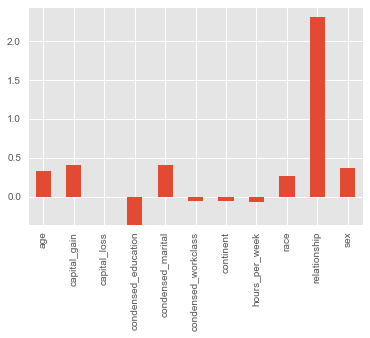

In [299]:
ax = weights.ix[1].plot(kind='bar')

## Support Vector Machine

In this section, we explore the use of SciKit's Support Vector Machine functions to predict the *income_binary* variable in our dataset. We compare the accuracy and training time for the SVC, LinearSVC and NuSVC algorithms.
 
LinearSVC is a linear support vector machine, while SVC and NuSVC are non-linear solutions with multiple kernel options. Along with the algorithms themselves, we also explored how tuning the parameters and the variables changed model accuracy, ultimately settling on the model that left us with the most accurate model trained in a reasonable amount of time. This was the standard SVC model using the default kernel 'rbf', default parameters, and reduced number of variables.
 
#### LinearSVC
 
In terms of training time, this algorithm is more efficient than the other SciKit SVM algorithms. While SVC and NuSVC offer increased accuracy, with algorithmic complexity greater than quadratic for *N* number of samples, training time for these two can be upwards of 3-4 hours on a faster-than-average personal machine. 
 
Our most accurate LinearSVC model has an accuracy of 83.6% using 0.8 as a penalty weight. It trains in less than a minute with a reduced number of variables. This model was highly inaccurate at around 50% when no variables were removed.
 
#### SVC
 
This model has an accuracy of 86.6% and was our most accurate SVM. Training time was around 5 minutes with a paired down number of variables and much higher when variables were not paired. The 'sigmoid' kernel was the fastest by a large margin, but did not provide the highest accuracy. Before pairing down the variables, both 'sigmoid' and 'rfd' kernels were predicting around 76%. 
 
#### NuSVC
 
Per SciKit's documentation, NuSVC is similar to SVC, but uses a 'nu' parameter which limits "an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors." To arrive at this solution, model training time can take hours, depending on the dataset's size. While we trained an instance of this algorithm below, its training time and minimal increase in accuracy ranks it below SVC in our book.
 
Our most accurate NusVC scored 86.6%, equal to our SVC.

In [300]:
#data import
import pandas as pd
import numpy as np

df = pd.read_csv('../data/master.csv')


to_drop = ['Unnamed: 0','workclass','education','education_num',
           'marital_status', 'native_country']

df = df.drop(to_drop, 1)

In [301]:
x = pd.get_dummies(df.drop('income_binary',1))
y = df.income_binary.values

In [302]:
from sklearn.model_selection import StratifiedKFold, train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=45)

In [303]:
from sklearn import metrics as mt
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC, NuSVC

### Linear SVC, SVC, and NuSVC

We calculate different variations of Support Vector Machines below, exploring accuracy and training time.

In [304]:
#this will run a for loop trying the Linear kernel at different penalty rates
#we can do this because the linear kernel isnt computationaly intensive at the # of variables
#we have kept in
penalty_rates = {}

for penalty in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    svm = LinearSVC(C=penalty)
    svm.fit(x_train,y_train)
    y_hat = svm.predict(x_test)
    
    accuracy = mt.accuracy_score(y_test,y_hat)
    
    penalty_rates[penalty] = accuracy

#save it in a DF for later
penalty_rates= pd.DataFrame(penalty_rates,index=['Accuracy']).transpose()

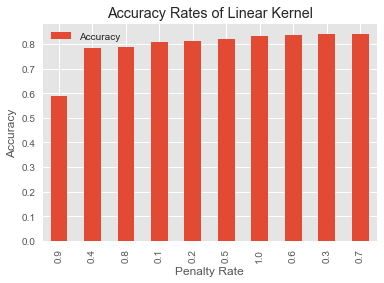

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#establish our plot and labels
ax = penalty_rates.sort_values('Accuracy').plot(kind='bar',title='Accuracy Rates of Linear Kernel')

ax.set_xlabel('Penalty Rate')
ax.set_ylabel('Accuracy')

In [308]:
# train the selected svm (linear @ 0.8 penalty)
svm_s = LinearSVC(C=0.7)
svm_s.fit(x_train,y_train)

#accuracy on out of sample data
y_hat = svm_s.predict(x_test)
accuracy = mt.accuracy_score(y_test,y_hat)
print('Accuracy : ', accuracy, '\n')


print('Confusion Matrix : \n\n', mt.confusion_matrix(y_test,y_hat),'\n')

#number of support vectors for each class
print('Intercept : ', svm_s.intercept_, '\n')

#coefficents of "support vectors" (its linear so closer to a linear model)
print('Coefficients : \n')
print(pd.Series(svm_s.coef_[0],index = x_train.columns).sort_values())



Accuracy :  0.83652369741 

Confusion Matrix : 

 [[7110  354]
 [1243 1062]] 

Intercept :  [-0.7110669] 

Coefficients : 

condensed_education_No High School Diploma        -0.652308
condensed_workclass_Uknown/Other                  -0.463698
sex_ Female                                       -0.459404
occupation_ Farming-fishing                       -0.442533
relationship_ Own-child                           -0.352404
relationship_ Unmarried                           -0.335480
condensed_education_High School Graduate          -0.332010
condensed_marital_Never                           -0.329677
occupation_ Other-service                         -0.314464
relationship_ Not-in-family                       -0.305708
occupation_ Priv-house-serv                       -0.305023
occupation_ Handlers-cleaners                     -0.286080
relationship_ Other-relative                      -0.268601
sex_ Male                                         -0.251662
race_ Amer-Indian-Eskimo            

In [309]:
svc = SVC()
svc.fit(x_train,y_train)
y_hat = svc.predict(x_test)

accuracy = mt.accuracy_score(y_test,y_hat)
print(accuracy)

0.866516531887


In [149]:
# Support vectors
print(svc.support_vectors_.shape)
print(svc.support_.shape)
print(svc.n_support_ )

(15781, 50)
(15781,)
[8491 7290]


In [158]:
svc.support_vectors_


array([[ 45.,   0.,   0., ...,   0.,   1.,   0.],
       [ 46.,   0.,   0., ...,   1.,   0.,   0.],
       [ 35.,   0.,   0., ...,   1.,   0.,   0.],
       ..., 
       [ 40.,   0.,   0., ...,   1.,   0.,   0.],
       [ 35.,   0.,   0., ...,   1.,   0.,   0.],
       [ 53.,   0.,   0., ...,   0.,   1.,   0.]])

In [138]:
#number of support vectors for each class
svc.n_support_

array([8491, 7290], dtype=int32)

In [228]:
len(svc.support_)

15781

In [140]:
len(svc.support_vectors_)

15781

In [141]:
nusvc = NuSVC(nu=.3)
nusvc.fit(x_train,y_train)
y_hat = nusvc.predict(x_test)

accuracy = mt.accuracy_score(y_test,y_hat)
print(accuracy)

0.866004708773


### Reviewing Support Vectors

Below we retrain a model and review the support vectors it selected. You can see the changes that the support vectors provide in the visualizations. The *age* variable has distinct distributions for each of its categories. 

In [161]:
from sklearn.model_selection import StratifiedShuffleSplit

if 'income_binary' in df:
    y = df['income_binary'].values #get values we need 
    del df['income_binary']        #get rid of the class label
    X = df.values                  #use everything else to predict 
    
X = pd.get_dummies(df).values

# Split the data into 20% Test and 80% Train
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)
sss.get_n_splits(X, y) #retreving the splits 

10

In [223]:
# Run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in sss.split(X,y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
X_train_scaled = scl_obj.transform(X_train) #apply to training
X_test_scaled = scl_obj.transform(X_test)   #apply to testing

In [224]:
# Train the model just as before
svm_clf = SVC(C=0.25, kernel='rbf', gamma='auto', random_state=True, decision_function_shape='ovr') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.844815231856
[[7038  393]
 [1123 1215]]


In [225]:
# Support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(14456, 41)
(14456,)
[7437 7019]


In [226]:
# Make a dataframe of the training data
df_tested_on = df.iloc[train_indices] # indices chosen for training
# Now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['income_binary'] = y[svm_clf.support_] # add back in the 'income_binary' Column to the pandas dataframe
df['income_binary'] = y # add it back into original data set
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14456 entries, 35646 to 32784
Data columns (total 12 columns):
age                    14456 non-null int64
relationship           14456 non-null object
race                   14456 non-null object
sex                    14456 non-null object
capital_gain           14456 non-null int64
capital_loss           14456 non-null int64
hours_per_week         14456 non-null int64
condensed_education    14456 non-null object
continent              14456 non-null object
condensed_marital      14456 non-null object
condensed_workclass    14456 non-null object
income_binary          14456 non-null object
dtypes: int64(4), object(8)
memory usage: 1.4+ MB


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Support Vector Visualizations

The graphs below show the differences between the original dataset and the support vectors. The separation in the support vectors is not as great as the separation in the original data. This is because the support vectors tend to include instances on the edge of the class boundaries. In addition, the support vectors tend to contain instances that are classified incorrectly in the training data set. 

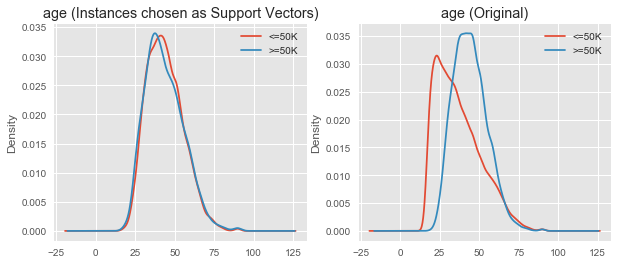

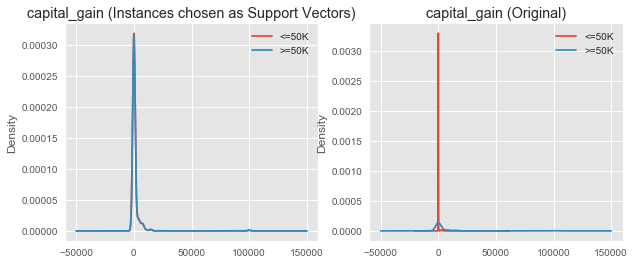

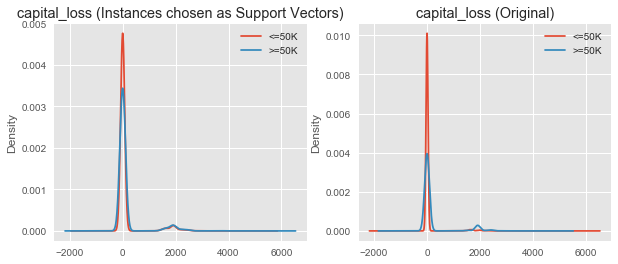

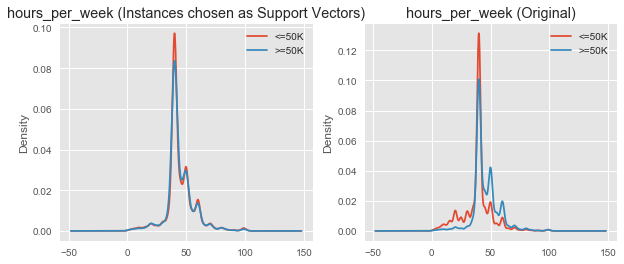

In [227]:

# Statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['income_binary'])
df_grouped = df.groupby(['income_binary'])

# plot KDE of Different variables
vars_to_plot = ['age','capital_gain','capital_loss', 'hours_per_week']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>=50K'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>=50K'])
    plt.title(v+' (Original)')